
# Analysis of the DiGeorge Syndrome Region in Chromosome 22

This notebook focuses on the analysis of genomic variants within the DiGeorge Syndrome region of chromosome 22.
We will first annotate the VCF file using VEP (Variant Effect Predictor) to enrich our data with functional annotations.
Then, we'll filter the variants to focus on the region of interest and perform various analyses to understand the impact of these variants.


## Step 1: Setup the Environment

We will begin by setting up the necessary environment for Spark and other tools, and then load the VCF file that contains the genomic data.


### Step 1.1: Install Dependencies


In [53]:
#!pip install colorama executing beautifulsoup4 requests

In [54]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt

# Install pyspark 3.3.2
!pip install pyspark==3.3.2
from pyspark.sql.functions import explode, col

# Set up the environment for Spark and other necessary tools
# Install Java 11 (compatible with Spark 3.3.2)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Configure Spark environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.10/dist-packages/pyspark"


In [55]:
# Download libraries from Hadoop and AWS
!wget -q https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.1/hadoop-aws-3.3.1.jar
!wget -q https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.12.374/aws-java-sdk-bundle-1.12.374.jar

# Move libraries to Spark directory
!mv hadoop-aws-3.3.1.jar $SPARK_HOME/jars/
!mv aws-java-sdk-bundle-1.12.374.jar $SPARK_HOME/jars/


#### BioPerl: Tools for Bioinformatics in Perl

**BioPerl** is a collection of Perl modules designed to facilitate the development of bioinformatics applications. These modules provide tools for common tasks in biological data processing, such as:

- **Sequence Manipulation**: Reading, writing, and converting between different sequence formats (FASTA, GenBank, EMBL, etc.).
- **Sequence Analysis**: Performing alignments, pattern searches, and handling annotations.
- **Access to Biological Databases**: Interacting with public databases like GenBank, SwissProt, and PDB, making it easier to download and process biological data.
- **Structure Handling**: Support for handling protein and nucleic acid structures.

In [56]:
# Install Perl and necessary dependencies
!apt-get update
!apt-get install -y libxml2-dev libexpat1-dev libssl-dev libgd-dev libncurses5-dev zlib1g-dev libbz2-dev \
liblzma-dev libmysqlclient-dev libcurl4-openssl-dev build-essential

# Install cpanminus and BioPerl
!apt-get install -y cpanminus
!cpanm Bio::Perl

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy Release
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

### Step 1.2: Configure Spark


In [57]:
from pyspark.sql import SparkSession
# Initiate Spark Session with detailed configuration
spark = SparkSession.builder \
    .appName("1000Genomes") \
    .config("spark.jars.packages",
            "org.apache.hadoop:hadoop-aws:3.3.6,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.565,"
            "io.projectglow:glow-spark3_2.12:1.1.1") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Verify Spark session
print("Spark Session created:", spark)
print("Spark Version:", spark.version)
print("Spark App Name:", spark.sparkContext.appName)
print("Spark Master:", spark.sparkContext.master)

Spark Session created: <pyspark.sql.session.SparkSession object at 0x7d0c7c3dc6d0>
Spark Version: 3.3.2
Spark App Name: 1000Genomes
Spark Master: local[*]



The Variant Effect Predictor (VEP) is a powerful tool provided by Ensembl that allows users to analyze the effects of genetic variants on genes, transcripts, and protein sequences. It is commonly used in bioinformatics to annotate genetic variants, predicting their impact on the function of genes.


## Step 2: Load the VCF Data

We will load the VCF file that contains genomic variants and filter it to focus on the DiGeorge Syndrome region in chromosome 22.


In [63]:
# Define the file paths
vcf_url = "https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
vcf_gz_path = "/content/output.vcf.gz"
vcf_path = "/content/output.vcf"

try:
    # Check if the VCF file has already been downloaded
    if not os.path.exists(vcf_path):
        print("VCF file not found, downloading...")
        !wget -q -O {vcf_gz_path} {vcf_url}

        # Unzip VCF file if the download was successful
        if os.path.exists(vcf_gz_path):
            print("Unzipping VCF file...")
            !gunzip {vcf_gz_path}
        else:
            raise FileNotFoundError(f"Downloaded file {vcf_gz_path} was not found.")

    else:
        print("VCF file already exists, skipping download and extraction.")

except Exception as e:
    print(f"An error occurred: {e}")

VCF file already exists, skipping download and extraction.


In [89]:
vcf_path = "/content/output.vcf"
vcf_df = spark.read.format("vcf").load(vcf_path)

vcf_df.show(10)

+----------+--------+--------+--------------------+---------------+--------------------+-----+-------+---------------------+---------+----------------+----------+-------+--------------------+-------+-------+------------------+--------------------+----------+-------+--------------------+--------------------+--------------------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+--------------------+--------------+--------+-----------+--------------------+
|contigName|   start|     end|               names|referenceAllele|    alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|         INFO_AC|INFO_CIEND|INFO_NS|         INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|         INFO_SAS_AF|INFO_CIPOS|INFO_AA|             INFO_AF|         INFO_EAS_AF|         INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|         INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes

In [65]:
#Understand the dataset schema
vcf_df.printSchema()

root
 |-- contigName: string (nullable = true)
 |-- start: long (nullable = true)
 |-- end: long (nullable = true)
 |-- names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAlleles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- qual: double (nullable = true)
 |-- filters: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- splitFromMultiAllelic: boolean (nullable = true)
 |-- INFO_MEND: integer (nullable = true)
 |-- INFO_AC: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_CIEND: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_NS: integer (nullable = true)
 |-- INFO_AFR_AF: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- INFO_VT: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- INFO_AN: integer (nullable = true)
 |-- INF

In [66]:
#Count rows to know the number of variants
vcf_df.count()

1103547

In [67]:
# Count the number of variants by type
variant_counts = vcf_df.groupBy("INFO_VT").count()
variant_counts.show()

+------------+-------+
|     INFO_VT|  count|
+------------+-------+
|[SNP, INDEL]|    871|
|       [SNP]|1059517|
|        [SV]|    782|
|     [INDEL]|  42377|
+------------+-------+



[SNP]: 1,059,517 variants are Single Nucleotide Polymorphisms.

[INDEL]: 42,377 variants are insertions or deletions.

[SV]: 782 are Structural Variants.

[SNP, INDEL]: 871 variants are identified as both SNPs and INDELs, which may indicate a complex variant or multiple annotations.

In [70]:
#Remove compressed files to free memory
vcf_gz_path = '/content/output.vcf.gz'
if os.path.exists(vcf_gz_path):
    os.remove(vcf_gz_path)
    print(f"Deleted {vcf_gz_path} to free up space.")
else:
    print(f"{vcf_gz_path} does not exist.")

Deleted ensembl-vep.zip to free up space.



## Step 3: Filter the Data and Perform Analysis

Now that we have the annotated data, we will filter it again for the region of interest and then proceed with various analyses, such as counting variant types and analyzing allele frequencies.


In [71]:
# Filter the annotated DataFrame for variants within the DiGeorge Syndrome region on chromosome 22
df_22q11 = vcf_df.filter(
    (vcf_df.start >= 18800000) &
    (vcf_df.start <= 21400000)
)

# Show the first few rows of the filtered annotated DataFrame
df_22q11.show(10)


+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+--

In [73]:
# Group by variant type and count the occurrences
df_22q11.groupBy("INFO_VT").count().show()

# Explode the 'alternateAlleles' column to create a row for each alternate allele
df_22q11 = df_22q11.withColumn("alt", explode(col("alternateAlleles")))

# Explode the 'INFO_AF' column and rename the exploded column to 'AlleleFreq'
df_22q11 = df_22q11.withColumn("AlleleFreq", explode(col("INFO_AF")))

# Describe allele frequencies
df_22q11.select("AlleleFreq").describe().show()

+------------+-----+
|     INFO_VT|count|
+------------+-----+
|[SNP, INDEL]|   52|
|       [SNP]|70262|
|        [SV]|   53|
|     [INDEL]| 2766|
+------------+-----+

+-------+-------------------+
|summary|         AlleleFreq|
+-------+-------------------+
|  count|              74493|
|   mean|0.03754631860549758|
| stddev|0.13305905668754203|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+




## Step 4: Visualize the Allele Frequency Distribution

We will visualize the distribution of allele frequencies within the DiGeorge Syndrome region using a histogram.


In [74]:
# Group by variant type and count the occurrences
df_22q11.groupBy("INFO_VT").count().show()

+------------+-----+
|     INFO_VT|count|
+------------+-----+
|[SNP, INDEL]|  213|
|       [SNP]|71081|
|        [SV]|   68|
|     [INDEL]| 3131|
+------------+-----+



In [75]:
from pyspark.sql.functions import explode, col

# Explode the 'alternateAlleles' column to create a row for each alternate allele
df_22q11 = df_22q11.withColumn("alt", explode(col("alternateAlleles")))

In [76]:
# Describe allele frequencies
# Explode the 'INFO_AF' column and rename the exploded column to 'AlleleFreq'
df_22q11 = df_22q11.withColumn("AlleleFreq", explode(col("INFO_AF")))

#Lets describe the allele frequency
df_22q11.select("AlleleFreq").describe().show()

+-------+--------------------+
|summary|          AlleleFreq|
+-------+--------------------+
|  count|               81993|
|   mean|0.041034968677512815|
| stddev| 0.13676641935893077|
|    min|                 0.0|
|    max|                 1.0|
+-------+--------------------+



- **Variant Distribution**: The majority of variants in the DiGeorge Syndrome region are SNPs.

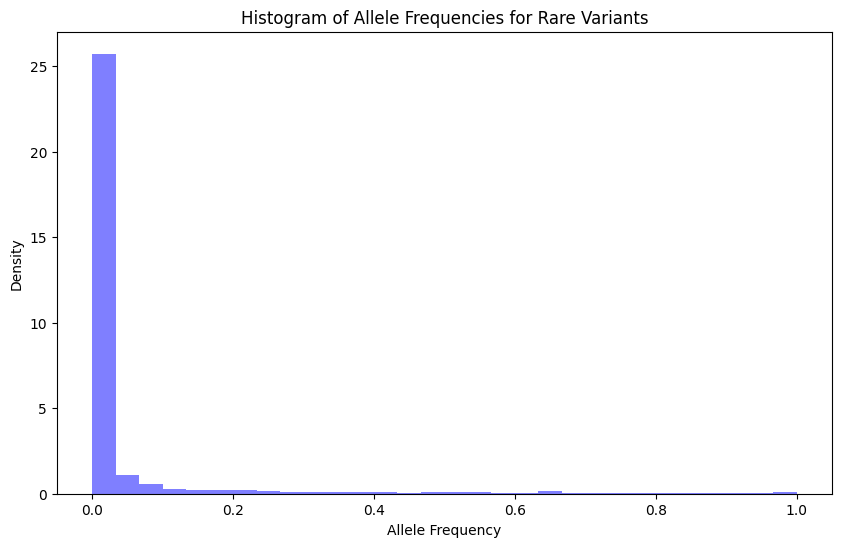

In [77]:
# Convert the DataFrame to a Pandas DataFrame for easier plotting
allele_freqs = df_22q11.select("AlleleFreq").toPandas()

# Plot a histogram of allele frequencies
plt.figure(figsize=(10, 6))
plt.hist(allele_freqs, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Histogram of Allele Frequencies for Rare Variants')
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.show()

High Peak at Low Frequencies: The tall peak near 0 indicates that the majority of variants have very low allele frequencies. These could represent rare variants that might have more significant impacts on individuals.

Sparse High-Frequency Variants: There are very few variants with higher allele frequencies, suggesting that most of the genetic variation in this region consists of rare variants.

## Step 5: Focus on Rare Variants

In [78]:
# Filter the DataFrame to obtain only rare variants (allele frequency < 0.05).
# This is important because rare variants often have a higher impact on genetic diseases.
rare_variants_df = df_22q11.filter(df_22q11["AlleleFreq"] < 0.05)

# Show the first 10 rows of the filtered DataFrame to verify that the filter was applied correctly.
rare_variants_df.show(10)

+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+---+----------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|alt|AlleleFreq|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+-

In [79]:
# Check if the consequence type column exists and group by it
rare_variants_df.groupBy("INFO_CS").count().show()

+----------+-----+
|   INFO_CS|count|
+----------+-----+
|      null|71985|
| DUP_uwash|   22|
| DEL_union|   30|
|    DUP_gs|   67|
|  L1_umary|    1|
| ALU_umary|    2|
| SVA_umary|    1|
|NUMT_umich|    1|
+----------+-----+



In [ ]:
consequence_counts = rare_variants_df.groupBy("INFO_CS").count().orderBy("count", ascending=False)
consequence_counts = consequence_counts.dropna(subset=["INFO_CS"])  # Add this line to drop rows with missing values
labels, values = zip(*consequence_counts.collect())

plt.figure(figsize=(12, 7))
plt.bar(labels, values, color='green')
plt.title('Distribution of Consequence Types for Rare Variants in DiGeorge Syndrome Region')
plt.xlabel('Consequence Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.show()

#Free memory
consequence_counts = None
labels = None
values = None

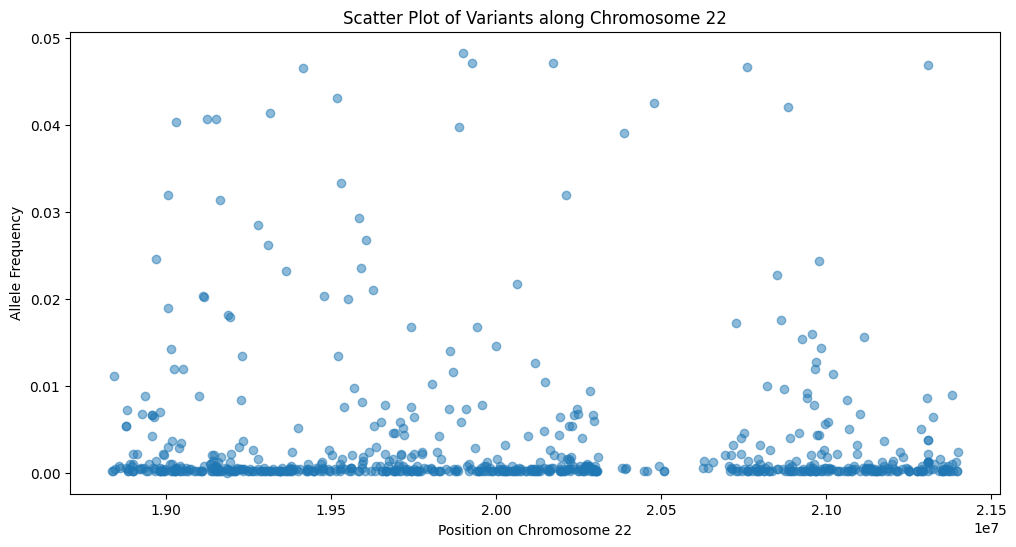

In [80]:
pos, allele_freqs = zip(*rare_variants_df.select("start", "AlleleFreq").sample(False, 0.01).collect())

plt.figure(figsize=(12, 6))
plt.scatter(pos, allele_freqs, alpha=0.5)
plt.title('Scatter Plot of Variants along Chromosome 22')
plt.xlabel('Position on Chromosome 22')
plt.ylabel('Allele Frequency')
plt.show()